# Implementing a CNN for the MNIST Dataset

Heather Marsh
1/26/25

I decided to use LeNet-5 as LeNet is often thought to of been one of the earliest convolutional neural networks with its architecture still being similar to what it is today.

# Import Pytorch libraries and APIs

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from torch.utils.data import Subset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# define the function of displaying multiple images
def show_images(images) -> None:
    n: int = images.size(0)

    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')

    plt.show(block=True)

# define the function of displaying multiple images
def show_images_withPred(images,label,pred,conf) -> None:
    n: int = images.size(0)

    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title("{} -> {}".format(label[i], pred[i]))
        #plt.title("Conf:{} \n {} -> {}".format(conf[i][pred[i]]*100,label[i], pred[i]))
        plt.axis('off')

    plt.show(block=True)

With the above code shown the machine learning framework has been loaded and then the deep neural network (DNN) needs to be built. The DNN will be used for image recognition. In order to train a DNN there are a couple of factors. The first factor is data, the dataset needs to be trained and tested. The second factor is the model as it needs to be a well-designed DNN that can be used for the training and testing. The third factor is criterion, it's a metric function to measure the distance between the current prediction with the label. The last factor is the optimizer, which is an algorithm to update the parameters of DNN based in the results of the criterion function.

#Data

The MNIST is a dataset of hand written digits which has 60,000 training entries and 10,000 testing images. The images are grayscale and have been normalized into 28 x 28 pixels in size.

In [ ]:
# Hyperparameters and Data loaders
num_epochs = 10
num_classes = 10
batch_size = 256
learning_rate = 0.001


DATA_PATH = 'data/'
MODEL_STORE_PATH = 'models/'

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor()])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 14.9MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.91MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw




/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In the code above the dataset was split into the training and testing sets and loaded.

# Convolutional  Neural Network Model

In [ ]:
# CNN
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(1, -1),
        )
        self.fc1 = nn.Linear(7 * 7 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        out = self.features(x)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out


model=LeNet()
model.cuda()
model.train()


LeNet(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

#Criterion and Optimizer

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

The loss function used us cross sentopy loss ehich is suitable for classification tasks as it measures the performance of a classification model whose output is a probability value between 0 and 1. Th optimizer chosen is the Adam Optimizer which is known for its efficiency in handling sparse gradients on noisy problems.

# Train Model

In [ ]:
model.train()
loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader)

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    outputs = model(images)

    loss = criterion(outputs, labels)
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list_cnn.append(correct / total)

    if (i%150 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100))

Epoch [1/10], Step [0/235], Loss: 2.3032, Accuracy: 12.50%
Epoch [1/10], Step [150/235], Loss: 0.1800, Accuracy: 93.75%
Epoch [2/10], Step [0/235], Loss: 0.1368, Accuracy: 95.31%
Epoch [2/10], Step [150/235], Loss: 0.1314, Accuracy: 95.70%
Epoch [3/10], Step [0/235], Loss: 0.0516, Accuracy: 98.83%
Epoch [3/10], Step [150/235], Loss: 0.0881, Accuracy: 96.88%
Epoch [4/10], Step [0/235], Loss: 0.0544, Accuracy: 98.44%
Epoch [4/10], Step [150/235], Loss: 0.0603, Accuracy: 98.05%
Epoch [5/10], Step [0/235], Loss: 0.0523, Accuracy: 98.05%
Epoch [5/10], Step [150/235], Loss: 0.0508, Accuracy: 98.44%
Epoch [6/10], Step [0/235], Loss: 0.0452, Accuracy: 98.83%
Epoch [6/10], Step [150/235], Loss: 0.0239, Accuracy: 99.61%
Epoch [7/10], Step [0/235], Loss: 0.0295, Accuracy: 99.61%
Epoch [7/10], Step [150/235], Loss: 0.0513, Accuracy: 97.66%
Epoch [8/10], Step [0/235], Loss: 0.0518, Accuracy: 98.44%
Epoch [8/10], Step [150/235], Loss: 0.0137, Accuracy: 99.61%
Epoch [9/10], Step [0/235], Loss: 0.0797

# Evaluate Model

In [ ]:
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

Accuracy of the model on the 10000 test images: 98.42 %


With the above code we are getting the accuracy of the model. The accuracy referes to the mer=tric used for evaluating performance, defined as the ratio of corerectly predicted observwations to the total observations. Here we can see the accuracy of the model on 10000 is 98.42%.

Incorrect Predictions:


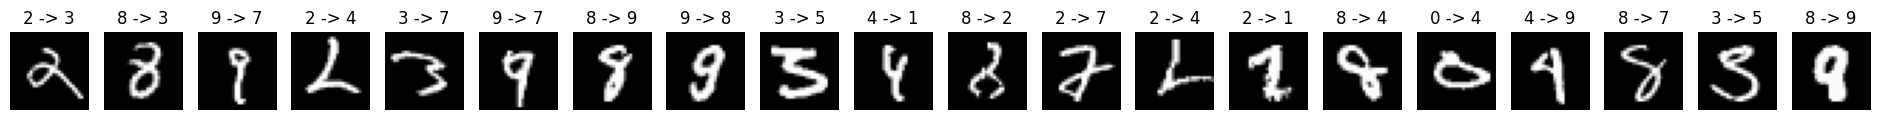

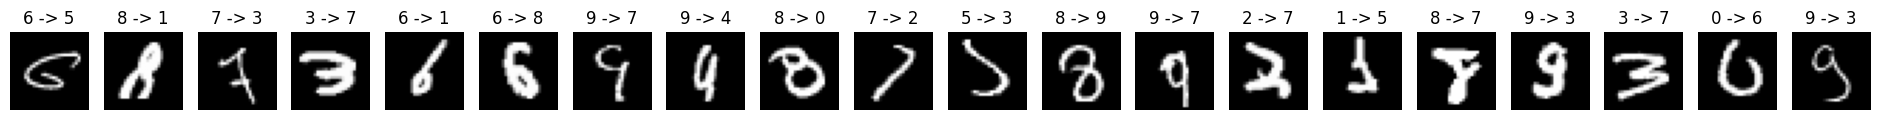

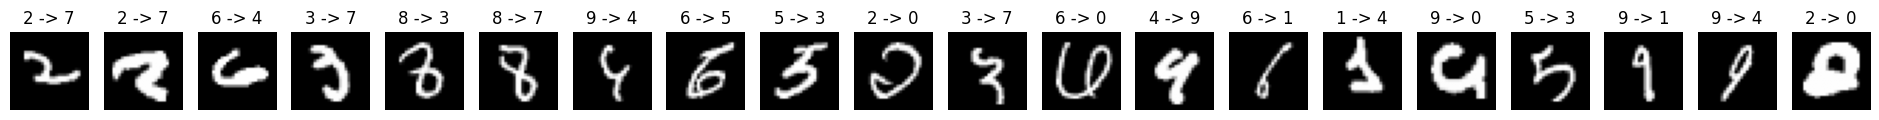

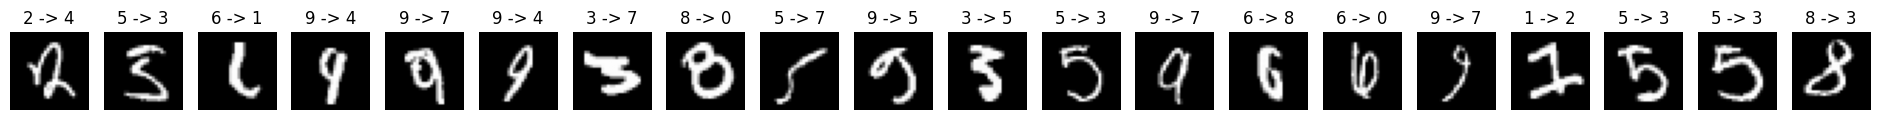



Correct Predictions:


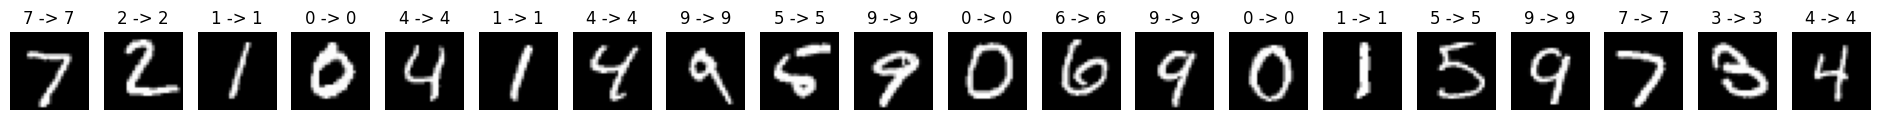

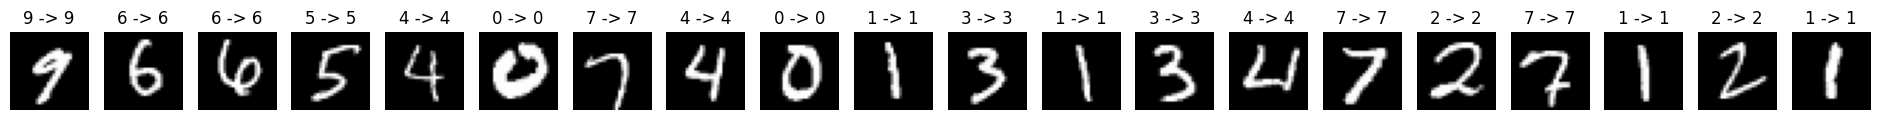

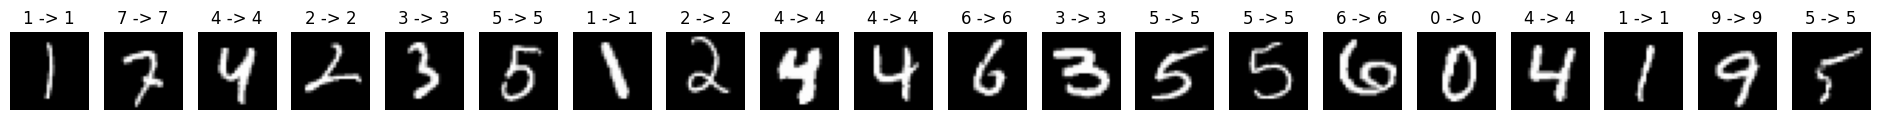

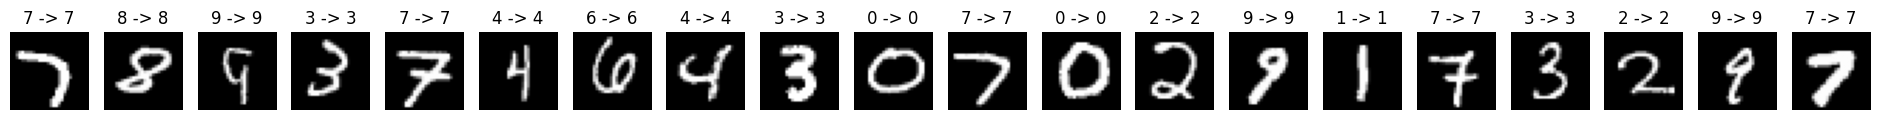

In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images.cuda()
        labels = labels.cuda()

        outputs = model(images)
        confidences = outputs.softmax(1)
        _, predicted = torch.max(outputs.data, 1)
        correct_idx = predicted == labels
        incorrect_idx = predicted != labels

        if i == 0:
            correct_images = images[correct_idx]
            correct_labels = labels[correct_idx]
            correct_pred = predicted[correct_idx]
            correct_conf = confidences[correct_idx]

            incorrect_images = images[incorrect_idx]
            incorrect_labels = labels[incorrect_idx]
            incorrect_pred = predicted[incorrect_idx]
            incorrect_conf = confidences[incorrect_idx]
        else:
            correct_images = torch.cat((correct_images, images[correct_idx]), 0)
            correct_labels = torch.cat((correct_labels, labels[correct_idx]), 0)
            correct_pred = torch.cat((correct_pred, predicted[correct_idx]), 0)
            correct_conf = torch.cat((correct_conf, confidences[correct_idx]), 0)

            incorrect_images = torch.cat((incorrect_images, images[incorrect_idx]), 0)
            incorrect_labels = torch.cat((incorrect_labels, labels[incorrect_idx]), 0)
            incorrect_pred = torch.cat((incorrect_pred, predicted[incorrect_idx]), 0)
            incorrect_conf = torch.cat((incorrect_conf, confidences[incorrect_idx]), 0)

print("Incorrect Predictions:")
plt_num = 20
for i in range(4):
    show_images_withPred(
        incorrect_images[i*plt_num:(i+1)*plt_num],
        incorrect_labels[i*plt_num:(i+1)*plt_num],
        incorrect_pred[i*plt_num:(i+1)*plt_num],
        incorrect_conf[i*plt_num:(i+1)*plt_num]
    )

print("\n\nCorrect Predictions:")
for i in range(4):
    show_images_withPred(
        correct_images[i*plt_num:(i+1)*plt_num],
        correct_labels[i*plt_num:(i+1)*plt_num],
        correct_pred[i*plt_num:(i+1)*plt_num],
        correct_conf[i*plt_num:(i+1)*plt_num]
    )

# Freeing memory by deleting large tensors after usage
del correct_images, correct_labels, correct_pred, correct_conf
del incorrect_images, incorrect_labels, incorrect_pred, incorrect_conf

Above we can see an output of the model detailing correct and incorrect predictions.

# Reflection

I used LeNet-5 for this tasks but it does have its limitations. LeNet-5 is sensitive to noise and other varations in input data. LeNet-5  can also overfit without proper regularization. This means that it would overfit on the training data and this could lead to bad generalization on unseen data, impacting teh accuracy of the model. LeNet-5 also has issues with scalability as it can handel small to mediumk sized datasets but in order to scale it for larger datasets or more complex data sets heavy modifications would need to be made or different architectures would need to be used.